In [19]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, AutoRegressiveBaseModel,AutoRegressiveBaseModelWithCovariates
from pytorch_forecasting.metrics import MAE,RMSE
import os
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pytorch_forecasting.models.nn import LSTM
from typing import Dict
from sklearn.preprocessing import StandardScaler
import random

In [20]:
stream = pd.read_pickle(os.path.join('..','data','processed','stream_processed.pkl'),compression= 'zip')
meteo = pd.read_pickle(os.path.join('..','data','processed','meteo_processed.pkl'),compression = 'zip')
stream

measurement_location,Datum,15202300,15205501,15207507,15210206,15212008,15212700,15213500,15214003,15214604,15216009,15217908,15221009,15228008,15241006,15242304,15243001,15246000,15247002,15247501
0,2014-01-01,14.4,17.2,19.8,3.87,8.66,9.66,0.433,2.35,0.207,1.66,0.921,0.671,2.59,0.253,0.870,1.26,2.35,0.355,0.120
1,2014-01-02,14.4,17.0,19.3,3.78,8.52,9.46,0.435,2.51,0.204,1.62,0.909,0.664,2.57,0.253,0.870,1.23,2.32,0.361,0.131
2,2014-01-03,14.1,16.6,19.3,3.78,8.40,9.42,0.429,2.61,0.201,1.60,0.907,0.641,2.58,0.253,0.871,1.23,2.30,0.362,0.130
3,2014-01-04,14.2,16.6,19.3,3.84,8.57,9.50,0.445,2.49,0.214,1.64,0.935,0.642,2.60,0.256,0.929,1.26,2.44,0.382,0.127
4,2014-01-05,16.4,18.4,20.6,4.36,9.94,10.80,0.545,2.86,0.267,1.80,1.130,0.690,3.10,0.300,1.150,1.61,3.14,0.561,0.175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2023-12-28,79.7,102.0,120.0,28.50,46.20,57.10,1.900,17.30,0.721,10.30,6.070,3.920,12.20,0.786,3.270,9.05,12.50,2.020,0.741
3649,2023-12-29,71.4,82.5,97.7,26.00,41.90,51.30,1.710,15.60,0.801,9.85,5.480,3.470,10.90,0.653,2.890,7.23,9.97,1.750,0.619
3650,2023-12-30,64.0,71.4,86.3,24.40,38.60,46.90,1.530,14.70,0.835,9.40,4.900,3.100,9.77,0.557,2.550,5.92,8.54,1.470,0.514
3651,2023-12-31,59.1,63.0,77.3,22.20,35.30,42.50,1.410,13.10,0.669,8.83,4.480,2.670,8.92,0.492,2.330,5.40,7.66,1.290,0.458


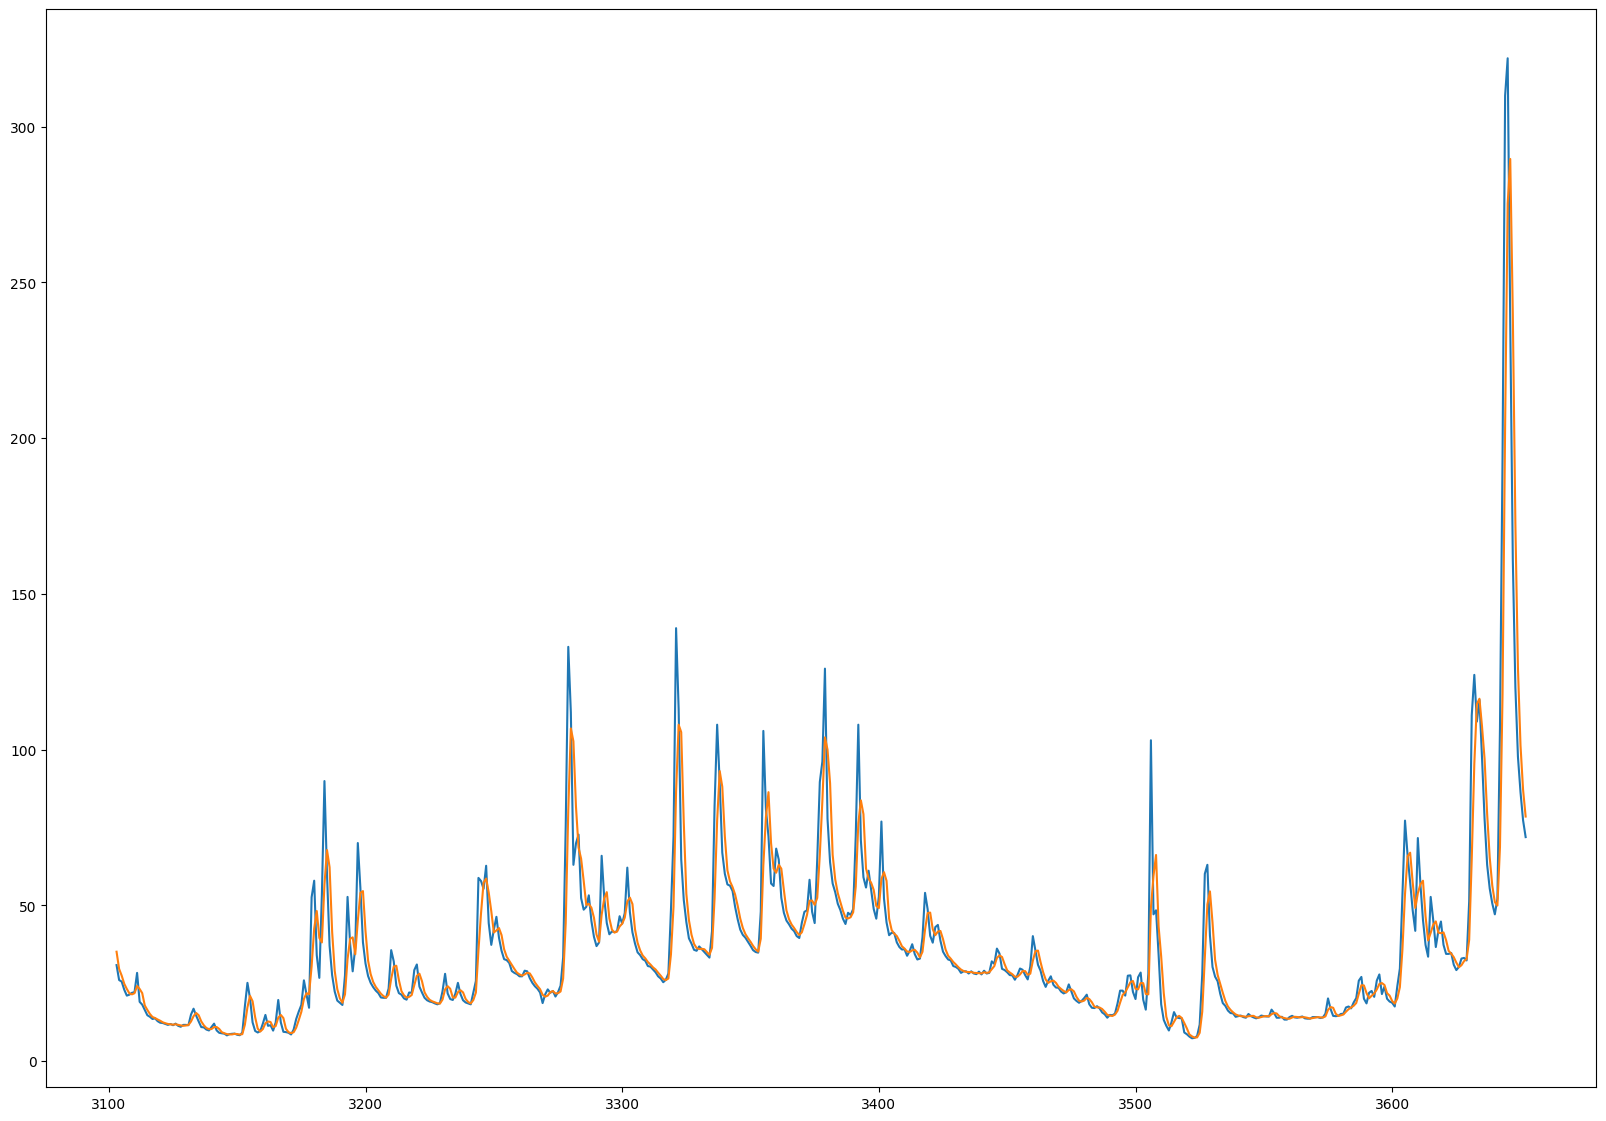

In [21]:
stream['15207507_smooth'] = stream['15207507'].rolling(window=3).mean()

plt.figure(figsize=(20, 14))

plt.plot(stream['15207507'].iloc[-550:])
plt.plot(stream['15207507_smooth'].iloc[-550:])

In [22]:
stream = stream.iloc[:3652]
meteo = meteo.drop(columns = 'date')
data = stream.join(meteo).drop(columns = 'Datum').dropna()
data['groups'] = 0
data['date'] = data.index
data

,15202300,15205501,15207507,15210206,15212008,15212700,15213500,15214003,15214604,15216009,...,tp_8600,tp_8711,tp_8712,tp_8720,tp_8731,tp_8732,tp_8800,tp_8900,groups,date
2,14.1,16.6,19.3,3.78,8.40,9.42,0.429,2.61,0.201,1.60,...,9.848191e-07,0.000001,9.627160e-07,3.152130e-07,6.812810e-07,1.552123e-07,2.603002e-07,6.997454e-07,0,2
3,14.2,16.6,19.3,3.84,8.57,9.50,0.445,2.49,0.214,1.64,...,2.306176e-04,0.000231,2.262798e-04,1.507445e-04,2.086118e-04,1.238402e-04,1.149645e-04,2.004822e-04,0,3
4,16.4,18.4,20.6,4.36,9.94,10.80,0.545,2.86,0.267,1.80,...,1.084148e-04,0.000105,1.079762e-04,1.110781e-04,1.135130e-04,1.155993e-04,1.087480e-04,1.086862e-04,0,4
5,18.3,21.4,24.4,4.38,10.70,11.50,0.524,2.87,0.237,1.78,...,2.335611e-05,0.000031,2.357872e-05,8.976913e-06,1.149020e-05,2.702179e-06,1.805063e-06,9.742068e-06,0,5
6,15.5,19.6,23.9,4.04,9.61,10.40,0.477,2.60,0.219,1.67,...,1.518327e-05,0.000012,1.410753e-05,4.084133e-06,1.565296e-05,3.595743e-06,2.389897e-06,1.327128e-05,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,95.2,138.0,161.0,32.60,54.00,67.80,2.210,21.50,0.993,9.91,...,1.199765e-05,0.000010,1.123335e-05,4.253323e-06,1.239131e-05,4.485424e-06,8.188290e-06,1.386781e-05,0,3647
3648,79.7,102.0,120.0,28.50,46.20,57.10,1.900,17.30,0.721,10.30,...,7.186941e-06,0.000008,7.407126e-06,8.299928e-06,6.351444e-06,6.934943e-06,4.598457e-06,5.399495e-06,0,3648
3649,71.4,82.5,97.7,26.00,41.90,51.30,1.710,15.60,0.801,9.85,...,4.738118e-05,0.000046,4.672316e-05,4.066719e-05,4.754517e-05,4.259339e-05,4.157456e-05,4.536385e-05,0,3649
3650,64.0,71.4,86.3,24.40,38.60,46.90,1.530,14.70,0.835,9.40,...,3.040644e-05,0.000025,2.828757e-05,8.883224e-06,3.148722e-05,9.169190e-06,2.475477e-05,3.975524e-05,0,3650


In [23]:
data[['15207507','15207507_smooth']]

,15207507,15207507_smooth
2,19.3,19.466667
3,19.3,19.300000
4,20.6,19.733333
5,24.4,21.433333
6,23.9,22.966667
...,...,...
3647,161.0,240.000000
3648,120.0,172.666667
3649,97.7,126.233333
3650,86.3,101.333333


In [24]:
max_pred_len = 2
enc_len = 364
training_cutoff = int(data["date"].max()*0.7) - max_pred_len
val_cutoff = int(data["date"].max()*0.85) - max_pred_len

training = TimeSeriesDataSet(
    data= data.iloc[: training_cutoff],
    target='15207507_smooth',#'15207507_smooth'
    group_ids=['groups'],#groups
    time_idx='date',#date
    max_encoder_length=enc_len,
    min_encoder_length=enc_len,
    min_prediction_length=max_pred_len,
    max_prediction_length=max_pred_len,
    time_varying_unknown_reals=['15207507_smooth'],
    time_varying_known_reals=data.columns[20:-2].values.tolist()#data.columns[20:-1].values.tolist()
)

validation = TimeSeriesDataSet.from_dataset(training,data.iloc[training_cutoff: val_cutoff],min_prediction_idx=training_cutoff+365,stop_randomization=True)

train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=2)


In [25]:
# max_pred_len = 1
# enc_len = 2
# training_cutoff = int(data["date"].max()*0.7) - max_pred_len
# val_cutoff = int(data["date"].max()*0.85) - max_pred_len

# training = TimeSeriesDataSet(
#     data= data.iloc[: training_cutoff],
#     target='15207507_smooth',#'15207507_smooth'
#     group_ids=['groups'],#groups
#     time_idx='date',#date
#     max_encoder_length=enc_len,
#     min_encoder_length=enc_len,
#     min_prediction_length=max_pred_len,
#     max_prediction_length=max_pred_len,
#     time_varying_unknown_reals=['15207507_smooth'],
#     time_varying_known_reals = data.columns[22:23].values.tolist(),
#     target_normalizer = None,
#     scalers = {col : None for col in data.columns[22:23]},
#     # lags = {col : [i for i in range(1,max_pred_len)] for col in data.columns[20:-2]}, #lags = {'d2m_8200' : [i for i in range(1,max_pred_len)]}
#     #data.columns[20:-1].values.tolist()
# )

# validation = TimeSeriesDataSet.from_dataset(training,data.iloc[training_cutoff: val_cutoff],min_prediction_idx=training_cutoff+365,stop_randomization=True)

# val_dataloader = validation.to_dataloader(train=False, batch_size=1, num_workers=2)

# next(iter(training))

In [26]:
class LSTMModel(AutoRegressiveBaseModel):
    def __init__(
        self,
        input_size:int,
        target: str,
        target_lags: Dict[str, Dict[str, int]],
        n_layers: int,
        hidden_size: int,
        dropout: float = 0.1,
        **kwargs,
    ):
        # arguments target and target_lags are required for autoregressive models
        # even though target_lags cannot be used without covariates
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)

        # use version of LSTM that can handle zero-length sequences
        self.lstm = LSTM(
            hidden_size=self.hparams.hidden_size,
            input_size=self.hparams.input_size,
            num_layers=self.hparams.n_layers,
            dropout=self.hparams.dropout,
            batch_first=True,
        )
        self.output_layer = nn.Linear(self.hparams.hidden_size, 1)

    def encode(self, x: Dict[str, torch.Tensor]):
        # we need at least one encoding step as because the target needs to be lagged by one time step
        # because we use the custom LSTM, we do not have to require encoder lengths of > 1
        # but can handle lengths of >= 1
        assert x["encoder_lengths"].min() >= 1
        input_vector = x["encoder_cont"].clone()

        # run through LSTM network
        _, hidden_state = self.lstm(
            input_vector, enforce_sorted=False  # passing the lengths directly
        )  # second ouput is not needed (hidden state)
        return hidden_state

    def decode(self, x: Dict[str, torch.Tensor], hidden_state):
        # again lag target by one
        input_vector = x["decoder_cont"].clone()
        input_vector[..., self.target_positions] = torch.roll(
            input_vector[..., self.target_positions], shifts=1, dims=1
        )
        # but this time fill in missing target from encoder_cont at the first time step instead of throwing it away
        last_encoder_target = x["encoder_cont"][
            torch.arange(x["encoder_cont"].size(0), device=x["encoder_cont"].device),
            x["encoder_lengths"] - 1,
            self.target_positions.unsqueeze(-1),
        ].T
        input_vector[:, 0, self.target_positions] = last_encoder_target

        if self.training:  # training mode
            lstm_output, _ = self.lstm(input_vector, hidden_state, lengths=x["decoder_lengths"], enforce_sorted=False)

            # transform into right shape
            prediction = self.output_layer(lstm_output)
            prediction = self.transform_output(prediction, target_scale=x["target_scale"])

            # predictions are not yet rescaled
            return prediction

        else:  # prediction mode
            target_pos = self.target_positions

            def decode_one(idx, lagged_targets, hidden_state):
                x = input_vector[:, [idx]]
                # overwrite at target positions
                x[:, 0, target_pos] = lagged_targets[-1]  # take most recent target (i.e. lag=1)
                lstm_output, hidden_state = self.lstm(x, hidden_state)
                # transform into right shape
                prediction = self.output_layer(lstm_output)[:, 0]  # take first timestep
                return prediction, hidden_state

            # make predictions which are fed into next step
            output = self.decode_autoregressive(
                decode_one,
                first_target=input_vector[:, 0, target_pos],
                first_hidden_state=hidden_state,
                target_scale=x["target_scale"],
                n_decoder_steps=input_vector.size(1),
            )

            # predictions are already rescaled
            return output

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        hidden_state = self.encode(x)  # encode to hidden state
        output = self.decode(x, hidden_state)  # decode leveraging hidden state

        return self.to_network_output(prediction=output)
    
    @property
    def target_positions(self) -> torch.LongTensor:
        """
        Positions of target variable(s) in covariates.

        Returns:
            torch.LongTensor: tensor of positions.
        """
        # todo: expand for categorical targets
        return torch.tensor(
            [-1],
            device=self.device,
            dtype=torch.long,
        )



model = LSTMModel.from_dataset(training,
                               input_size = 96,
                               learning_rate = 0.001,
                               n_layers=1,
                               hidden_size = 128,
                               loss = MAE(),
                               dropout = 0.2,
                               optimizer = 'adam',
                               reduce_on_plateau_patience = 10,
                               weight_decay = 0.001)

/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [27]:
# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',  # metric to monitor
#     patience=5,          # number of epochs with no improvement after which training will be stopped
#     mode='min',          # 'min' if the monitored metric should be minimized
#     verbose=True         # print messages when early stopping
# )

In [28]:
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=100,
    # callbacks=[early_stopping_callback],
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
# fit network
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MAE        | 0     
1 | logging_metrics | ModuleList | 0     
2 | lstm            | LSTM       | 115 K 
3 | output_layer    | Linear     | 129   
-----------------------------------------------
115 K     Trainable params
0         Non-trainable params
115 K     Total params
0.463     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 34/34 [00:06<00:00,  4.87it/s, v_num=55, train_loss_step=1.380, val_loss=4.000, train_loss_epoch=1.500]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 34/34 [00:07<00:00,  4.85it/s, v_num=55, train_loss_step=1.380, val_loss=4.000, train_loss_epoch=1.500]


In [30]:
best_model_path = trainer.checkpoint_callback.best_model_path
#os.path.join(,'lightning_logs','version_9','checkpoints','epoch=9-step=680.ckpt')
best_lstm = LSTMModel.load_from_checkpoint(best_model_path)#os.path.join(best_model_path,'lightning_logs','version_24','checkpoints','epoch=19-step=680.ckpt'))

In [31]:
test = TimeSeriesDataSet.from_dataset(training,data.iloc[val_cutoff:],min_prediction_idx = val_cutoff+365,stop_randomization=True)
test_dataloader = test.to_dataloader(train=False, batch_size=2, num_workers=2)
len(test)

184

In [32]:
predictions = best_lstm.predict(test_dataloader,return_y=True,trainer_kwargs=dict(accelerator="cpu"))


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/lemarx/anaconda3/envs/Climate_Data/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


In [33]:
def kge(inputs,targets):
    r = torch.corrcoef(torch.stack((inputs.squeeze(),targets)))[0][1]
    alpha = inputs.std()/targets.std()
    beta = inputs.mean()/targets.mean()
    kge = torch.sqrt(torch.square(r-1) + torch.square(alpha-1) + torch.square(beta-1))
    return 1 - kge

In [34]:
kge(torch.tensor(stream['15207507_smooth'].iloc[-184:].values),predictions.output[:,max_pred_len-1])#[:,max_pred_len-1]

tensor(0.7311, dtype=torch.float64)

In [19]:
predictions.output.shape

torch.Size([184, 1])

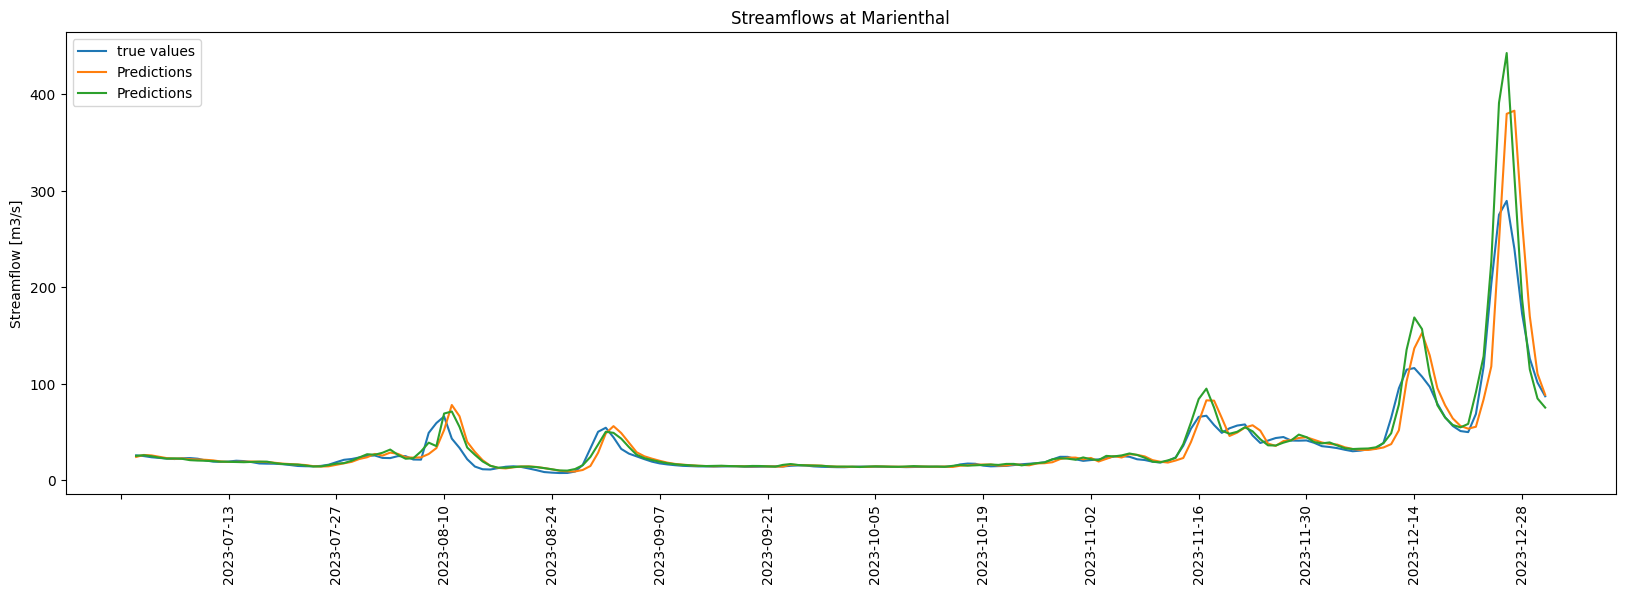

In [35]:
import matplotlib.dates as mdates


stream_plot = stream.set_index('Datum')
predictions_np = predictions.output.squeeze().numpy()#[:,max_pred_len-1]
# true_values_np = predictions.y[0].view(-1, 1).squeeze().numpy()

# Plotting

plt.figure(figsize=(20, 6))


plt.plot(stream_plot.index[-184:],stream_plot['15207507_smooth'].iloc[-184:].values,  label = 'true values')

plt.plot(predictions_np, label='Predictions')


plt.ylabel('Streamflow [m3/s]')
plt.title('Streamflows at Marienthal')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.legend()
plt.xticks(rotation=90)
plt.show()